In [1]:
# pre_processing
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer

# selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb

# metrics
from sklearn.metrics import f1_score, plot_roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import scipy
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

# general
import pandas as pd
import numpy as np
from time import time
from Titanic_utils import *
import matplotlib.pyplot as plt
plt.rcParams.update({'text.color' : "k",
                     'axes.labelcolor' : "w",
                     'xtick.color' : "w",
                     'ytick.color' : "w"})

we need to be able to reproduce features from the train to the test,
so we'll create a custom sklean preprocessor transformer object.
[inspiration](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py)

In [2]:
class Preprocessor(BaseEstimator,TransformerMixin):
    """
    A preprocessor transformer class for the Titanic dataset.
    The pre-processing stages are as follows:
    - Use title of names as a feature.
    - Fill NaN ages by the mean age grouped by Title,
        the highest correlating feature.
    - parse deck level from 'Cabin' feature.
    - drop Name, Cabin, Ticket as they were used for another feature,
        or aren't worth the trouble.
    - one-hot categorical data.
    - possibly add/remove columns, based on feature exploration
        and false analysis (added ability to define what columns to drop,
        if they prove to be bad).
    """

    def fit(self, X, *y):
        """
        fit the preprocessor parameters to the training data.
        :param X: data
        :param y: labels
        :return: none (transformer is now fitted).
        """
        X = X.copy()
        X.reset_index(inplace=True,drop=True)
        # create Rare title for titles without enough examples (we consider
        # it to be unknown).
        X['Title'] = X['Name'].apply(lambda x: x.split(',')[1].split()[0])
        self.freq_titles = X['Title'].value_counts()
        self.freq_titles = self.freq_titles[self.freq_titles>4].index
        X.loc[~X['Title'].isin(self.freq_titles),'Title'] = 'Rare'
        self.ages = X.groupby('Title')['Age'].mean()
        splitted_cabin = X['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x: x[0])
        X['Cabin_Deck'] = pd.DataFrame(splitted_cabin.tolist(), index = splitted_cabin.index)
        if(self.one_hot_cat):
            self.ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
            self.ohe.fit(X[self.cat_columns].fillna(-1).astype(str))
        else:
            # catboost/LightGBM
            X[self.cat_text_cols] = X[self.cat_text_cols].fillna('nan')
            self.ord_enc = OrdinalEncoderWithUnknown()
            self.ord_enc.fit(X[self.cat_text_cols])
        # addition
        X['SibSp^2'] = X['SibSp']**2
        self.scaler = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), ['SibSp^2','Fare','Age'])],remainder='drop')
        self.scaler.fit(X[['SibSp^2','Fare','Age']])

    def add_columns_to_drop(self,cols):
        self.drop_columns.append(cols)

    def remove_columns_to_drop(self,cols):
        self.drop_columns.remove(cols)

    def drop_try(self,df):
        '''
        try to drop columns in 'self.columns_to_drop'.
        if columns doesn't exist - do nothing.
        :param df:
        :return:
        '''
        for col in self.drop_columns:
         try:
             df.drop(col,axis=1,inplace=True)
         except:
             pass
        return df

    def transform(self,X, *y):
        """
        transform the test/cv data to the same format as the train data.
        :param X: data
        :param y: none (unused for preprocessing).
        :return: preprocessed data.
        """
        X = X.copy()
        X.reset_index(inplace=True,drop=True)
        # ticket: just shows family relations, which is covered in parch and sibsp anyway.
        # name: we already extracted titles
        # cabin: we used it for deck feature, no need for it afterwards.
        # one_hot categories all at once, drop originals afterwards.
        # name_to_titles
        X['Title'] = X['Name'].apply(lambda x: x.split(',')[1].split()[0])
        X.loc[~X['Title'].isin(self.freq_titles),'Title'] = 'Rare'
        # fill age NaNs by titles
        # X.Age = self.age_imputer.transform(X.select_dtypes(exclude=object))[:,1]
        X.Age = X.apply(lambda x : self.ages[x['Title']] if np.isnan(x['Age']) else x['Age'],axis=1)
        # cabin_to_deck_no (keep NaNs as is, column is cabin_deck_-1)
        splitted_cabin = X['Cabin'].dropna().str.split(pat='[\d ]').apply(lambda x: x[0])
        X['Cabin_Deck'] = pd.DataFrame(splitted_cabin.tolist(), index = splitted_cabin.index)
        # as sex has only 2 categories, just binarize it.
        X['Sex'] = (X['Sex']=='male').astype(int)
        # found out from feature exploration that sibsp^2 makes a difference.
        X['SibSp^2'] = X['SibSp']**2
        # one_hot categories all at once, drop originals afterwards.
        if(self.one_hot_cat):
            ohe_array = self.ohe.transform(X[self.cat_columns].fillna(-1).astype(str))
            ohe_df = pd.DataFrame(ohe_array, columns=self.ohe.get_feature_names(self.cat_columns))
            X = pd.concat([X,ohe_df],axis='columns').drop(self.cat_columns,axis='columns')
        else:
            X[self.cat_text_cols] = self.ord_enc.transform(X[self.cat_text_cols].fillna('nan')).astype(int)
        X[['SibSp^2','Fare','Age']] = self.scaler.transform(X[['SibSp^2','Fare','Age']])
        X = self.drop_try(X)
        self.features = X.columns
        return X

    def fit_transform(self,X, *y):
        """
        fit the preprocessor parameters to the training data,
        and transform the train data as well (using tranform func)
        :param data:
        X_train data, to fit the data preprocessor transformer.
        :return:
        -------
        X_new : ndarray array of shape (n_samples, n_features_new)
            Transformed array.
        """
        self.fit(X,y)
        return self.transform(X,y)
    def get_features(self):
        return self.features
    def __init__(self,one_hot_cat = True,cols_to_drop = None):
        self.one_hot_cat = one_hot_cat
        self.drop_columns = ['Ticket','Name','Cabin']
        if cols_to_drop is not None :
            self.drop_columns += cols_to_drop
        self.cat_columns = ['Pclass','Title','SibSp','Embarked','Cabin_Deck']
        self.cat_text_cols = ['Title','Embarked','Cabin_Deck']

# data and classifier setup

In [3]:
data = pd.read_csv('titanic.csv')
data.dtypes
X, X_test, y, y_test = train_test_split(data.drop('Survived',axis=1),
                                        data['Survived'], test_size=0.2,
                                        random_state=42)

## Baseline Value
method: just through away everything that isn't numeric,
fill with median (robust to outliers), One_hot categories, done.
taken from [here](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html)

In [4]:
numeric_features = ['Age', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())])
categorical_features = ['Pclass','Sex','SibSp','Parch','Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# note that Col Transformer returns only the transformed columns (unless remainder param set to 'passthrough')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
baseline_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

scores = cross_val_score_regular(baseline_clf,X,y)
print('baseline scores (cv and train): ',*scores,sep='\n')

baseline scores (cv and train): 
[0.80295464 0.77913025 0.77293771 0.71675084 0.79128683]
0.7726120561847719
[0.78336618 0.77082512 0.77566328 0.7901736  0.77581607]
0.7791688508252099


In [5]:
pp = Preprocessor()
pp.fit(X)
pp.transform(X).dtypes

Sex                int32
Age              float64
Parch              int64
Fare             float64
SibSp^2          float64
Pclass_1         float64
Pclass_2         float64
Pclass_3         float64
Title_Dr.        float64
Title_Master.    float64
Title_Miss.      float64
Title_Mr.        float64
Title_Mrs.       float64
Title_Rare       float64
SibSp_0          float64
SibSp_1          float64
SibSp_2          float64
SibSp_3          float64
SibSp_4          float64
SibSp_5          float64
SibSp_8          float64
Embarked_-1      float64
Embarked_C       float64
Embarked_Q       float64
Embarked_S       float64
Cabin_Deck_-1    float64
Cabin_Deck_A     float64
Cabin_Deck_B     float64
Cabin_Deck_C     float64
Cabin_Deck_D     float64
Cabin_Deck_E     float64
Cabin_Deck_F     float64
Cabin_Deck_G     float64
Cabin_Deck_T     float64
dtype: object

In [6]:
# general structure of pipeline:
from sklearn import set_config
set_config(display='diagram')
baseline_clf
set_config(display='text')

## catboost and lightgbm
 they can handle categorical data, so we'll start off with them, as they need a special setup.

In [30]:
cb_clf = CatBoostClassifier(iterations=100,
                            task_type="GPU",
                            devices='0=1',
                            cat_features=['Pclass','Title','SibSp',
                                          'Parch','Embarked','Cabin_Deck'],
                            verbose=False)
# cb = False
# if(cb):
pipe = Pipeline([('pre_processing',Preprocessor(one_hot_cat=False)),('classifier',cb_clf)])
cv_scores = cross_val_score_regular(pipe,X,y)
print('catboost cv and train scores: ',*cv_scores,sep='\n')
# else:
lgb_params = {'classifier__categorical_feature':['Pclass','Title','SibSp','Parch','Embarked','Cabin_Deck']}
lgb_clf = lgb.sklearn.LGBMClassifier()
pipe = Pipeline([('pre_processing',Preprocessor(one_hot_cat=False)),('classifier',lgb_clf)])
pipe.fit(X,y)
cv_scores = cross_val_score_regular(pipe,X,y)
print('lgbm cv and train scores: ',*cv_scores,sep='\n')

catboost cv and train scores: 
[0.77517686 0.8141906  0.78430135 0.77861953 0.83644265]
0.7977461973990487
[0.88446328 0.86012351 0.87232231 0.86858827 0.85734463]
0.8685683989629538
lgbm cv and train scores: 
[0.77517686 0.8363504  0.80639731 0.78787879 0.78927284]
0.7990152389558791
[0.96129287 0.94410064 0.94546348 0.95018015 0.94985876]
0.9501791791347216


## fitting classifiers with hyper-parameters

setting up classifiers and their parameters:

In [8]:
names = ["Logistic_Regression",
         "Linear_SVM", "RBF_SVM",
         "Decision_Tree",
         "Neural_Net", "AdaBoost",
         "Random_Forest","XGBoost"]
param_grid = {'Logistic_Regression':
                  {'classifier__C':loguniform(1e-3, 1e3),
                   'classifier__penalty':['l1','l2']},
              'Linear_SVM':
                  {'classifier__C': scipy.stats.expon(scale=100),
                    'classifier__gamma': scipy.stats.expon(scale=.1),
                    'classifier__kernel': ['rbf'],
                    'classifier__class_weight':['balanced', None]},
              'RBF_SVM':
                  {'classifier__C': loguniform(1e0, 1e3),
                    'classifier__gamma': loguniform(1e-4, 1e-3),
                    'classifier__kernel': ['rbf']},
              'Decision_Tree':
                  {"classifier__max_depth": np.linspace(2,10,5),
                     "classifier__max_features": range(1,9),
                     "classifier__min_samples_leaf": range(3,9),
                     "classifier__criterion": ["gini", "entropy"]},
              'Neural_Net':{
                  'classifier__solver': ['lbfgs','adam'],
                  'classifier__max_iter': [500,1000,1500],
                  'classifier__alpha': 10.0 ** -np.arange(1, 7),
                  'classifier__hidden_layer_sizes':np.arange(5, 12)
              },
              'AdaBoost':{
                  'classifier__n_estimators': [100,200,500],
                  'classifier__learning_rate' : loguniform(1e-2, 1e0),
                  'classifier__base_estimator__max_depth' : [4,5,6,7,8]
              },
              'Random_Forest':{
                  'classifier__n_estimators': [200, 500],
                  'classifier__max_features': ['auto', 'sqrt', 'log2'],
                  'classifier__max_depth' : [4,5,6,7,8],
                  'classifier__criterion' :['gini', 'entropy']},
              'XGBoost':{
                  'classifier__learning_rate':loguniform(1e-2, 1e0),
                  'classifier__gamma':[0,1,5],
                  'classifier__n_estimators': [500,750,1000],
                  'classifier__max_depth': [3,6,8],
                  'classifier__subsample': uniform(loc=0.8,scale=0.2),
                  'classifier__colsample_bytree': uniform(loc=0.8,scale=0.2)
              }}
classifiers = [
    LogisticRegression(C=0.3,n_jobs=-1,solver='newton-cg'),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(hidden_layer_sizes=(5,3),alpha=1, max_iter=1000),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),n_estimators=500),
    RandomForestClassifier(max_depth=9, n_estimators=400, max_features=1),
    xgb.XGBClassifier(max_depth=10,learning_rate =0.3,n_estimators=500,
                      objective="reg:squarederror", n_jobs = -1,random_state=42),
]

## Random Search on each Clf (20 rounds)

In [9]:
scores = []
random_searches = {}
for (name,clf) in zip(names, classifiers):
    pipeclf = Pipeline([('pre_processing',Preprocessor()),('classifier',clf)])
    print(name)
    n_iter_search = 20
    random_searches[name] = RandomizedSearchCV(pipeclf,param_grid[name],
                                               n_jobs=-1,scoring='roc_auc',
                                               n_iter=n_iter_search,
                                               return_train_score=True)
    start = time()
    random_search = random_searches[name]
    random_search.fit(X, y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time() - start), n_iter_search))
    print(random_search.best_estimator_,'\nauc: ',random_search.best_score_)
    scores.append((name,random_search.best_score_))

Logistic_Regression


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 6.72 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 LogisticRegression(C=0.10619108399169305, n_jobs=-1,
                                    solver='newton-cg'))]) 
auc:  0.8625159222427083
Linear_SVM


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 4.21 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 SVC(C=16.493994305284705, gamma=0.0190010899985659))]) 
auc:  0.8624328267838444
RBF_SVM


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 3.86 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 SVC(C=25.306063066623494, gamma=0.00012337949527837963))]) 
auc:  0.8566019667739511
Decision_Tree


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 3.34 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=8.0, max_features=8,
                                        min_samples_leaf=6))]) 
auc:  0.8290599175987134
Neural_Net


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 19.76 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 MLPClassifier(alpha=1e-06, hidden_layer_sizes=8,
                               max_iter=1500))]) 
auc:  0.8613236233082004
AdaBoost


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 19.30 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                                    learning_rate=0.021080020568984736,
                                    n_estimators=500))]) 
auc:  0.838199994253895
Random_Forest


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 16.74 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 RandomForestClassifier(max_depth=6, max_features='log2',
                                        n_estimators=200))]) 
auc:  0.86191175588833
XGBoost


C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


RandomizedSearchCV took 28.20 seconds for 20 candidates parameter settings.
Pipeline(steps=[('pre_processing', Preprocessor()),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8162398049146752, gamma=1,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.0592178042115199,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=500,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='reg:squarederror', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                

C:\Users\Ariel\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


# False analysis

In [10]:
# save searches.
from joblib import dump, load
dump(random_searches, 'random_searches.joblib')

['random_searches.joblib']

In [11]:
random_searches = load('random_searches.joblib')

see scores of the best classifiers.

In [12]:
random_searches_list = list(random_searches.items())
random_searches_list.sort(key=lambda x:x[1].best_score_,reverse=True)
for (name,rand_search) in random_searches_list[:3]:
    print(name,'\n')
    print('best index: ',rand_search.best_index_)
    for metric in rand_search.cv_results_.items():
        print(metric[0],metric[1][rand_search.best_index_])
    print('\n\n')

XGBoost 

best index:  2
mean_fit_time 0.6515990734100342
std_fit_time 0.012449873920408389
mean_score_time 0.04359965324401856
std_score_time 0.0050041577898722895
param_classifier__colsample_bytree 0.8162398049146752
param_classifier__gamma 1
param_classifier__learning_rate 0.0592178042115199
param_classifier__max_depth 3
param_classifier__n_estimators 500
param_classifier__subsample 0.8025175231674534
params {'classifier__colsample_bytree': 0.8162398049146752, 'classifier__gamma': 1, 'classifier__learning_rate': 0.0592178042115199, 'classifier__max_depth': 3, 'classifier__n_estimators': 500, 'classifier__subsample': 0.8025175231674534}
split0_test_score 0.8315647107781939
split1_test_score 0.9204119850187266
split2_test_score 0.8207070707070707
split3_test_score 0.8450126262626263
split4_test_score 0.8997244011023956
mean_test_score 0.8634841587738027
std_test_score 0.039354950138787224
rank_test_score 1
split0_train_score 0.9204046774405465
split1_train_score 0.890224674812771
spli

In [13]:
best_clf = random_searches_list[0][1].best_estimator_
cols = best_clf['pre_processing'].fit_transform(X).columns
importances = best_clf['classifier'].feature_importances_
df = pd.DataFrame(np.c_[cols,importances],columns=['Columns','Importances'])
print(df)
# print(list(df[df['Importances']==0]['Columns']))

          Columns Importances
0             Sex     0.17875
1             Age   0.0321568
2           Parch   0.0218493
3            Fare   0.0437958
4         SibSp^2   0.0443479
5        Pclass_1   0.0164144
6        Pclass_2           0
7        Pclass_3    0.117786
8       Title_Dr.   0.0299772
9   Title_Master.    0.044601
10    Title_Miss.           0
11      Title_Mr.    0.284978
12     Title_Mrs.   0.0244918
13     Title_Rare           0
14        SibSp_0           0
15        SibSp_1           0
16        SibSp_2           0
17        SibSp_3           0
18        SibSp_4           0
19        SibSp_5           0
20        SibSp_8           0
21    Embarked_-1           0
22     Embarked_C    0.030049
23     Embarked_Q           0
24     Embarked_S    0.037153
25  Cabin_Deck_-1   0.0574137
26   Cabin_Deck_A           0
27   Cabin_Deck_B           0
28   Cabin_Deck_C           0
29   Cabin_Deck_D           0
30   Cabin_Deck_E    0.036236
31   Cabin_Deck_F           0
32   Cabin

In [14]:
feature_importances,fp,fn = get_errors_and_features(best_clf,X,y)
feature_importances

[[81  8]
 [16 38]]
fp: 
      Pclass                                               Name     Sex   Age  \
7         2              Lahtinen, Mrs. William (Anna Sylfven)  female  26.0   
35        1                          Brewe, Dr. Arthur Jackson    male   NaN   
36        3                     Palsson, Master. Gosta Leonard    male   2.0   
42        2             Yrois, Miss. Henriette ("Mrs Harbeck")  female  24.0   
52        3                                Canavan, Miss. Mary  female  21.0   
114       3                      Boulos, Mrs. Joseph (Sultana)  female   NaN   
128       3     Robins, Mrs. Alexander A (Grace Charity Laury)  female  47.0   
132       2  Turpin, Mrs. William John Robert (Dorothy Ann ...  female  27.0   

     SibSp  Parch     Ticket     Fare Cabin Embarked  
7        1      1     250651  26.0000   NaN        S  
35       0      0     112379  39.6000   NaN        C  
36       3      1     349909  21.0750   NaN        S  
42       0      0     248747  13.0

array([[0.12554821372032166, 'Sex'],
       [0.027515694499015808, 'Age'],
       [0.018225906416773796, 'Parch'],
       [0.03561985492706299, 'Fare'],
       [0.03603928163647652, 'SibSp^2'],
       [0.05899054557085037, 'Pclass_1'],
       [0.0656723603606224, 'Pclass_2'],
       [0.07947859913110733, 'Pclass_3'],
       [0.0, 'Title_Dr.'],
       [0.0446961335837841, 'Title_Master.'],
       [0.008875944651663303, 'Title_Miss.'],
       [0.224235400557518, 'Title_Mr.'],
       [0.03947775810956955, 'Title_Mrs.'],
       [0.03019719384610653, 'Title_Rare'],
       [0.0, 'SibSp_0'],
       [0.0, 'SibSp_1'],
       [0.0, 'SibSp_2'],
       [0.0, 'SibSp_3'],
       [0.0, 'SibSp_4'],
       [0.0, 'SibSp_5'],
       [0.0, 'SibSp_8'],
       [0.0, 'Embarked_-1'],
       [0.021867332980036736, 'Embarked_C'],
       [0.0, 'Embarked_Q'],
       [0.031197141855955124, 'Embarked_S'],
       [0.024834902957081795, 'Cabin_Deck_-1'],
       [0.03325647488236427, 'Cabin_Deck_A'],
       [0.0, 'Cab

We see that most misclassifications are fn.
let's take a closer look:

In [15]:
best_clf['pre_processing'].transform(fn)['Title_Mr.']

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     0.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
Name: Title_Mr., dtype: float64

we see that almost all fn's are men ('Mr.' to be specific). In addition,
we see that the classifier puts a large emphasis on both title and one's Sex.\
Since we can assume the Titles cover one's sex (a 'Mrs.' is a female, etc),\
we'll try to remove the Sex, as it has a high correlation with the titles.
to prove this, we'll check it's chi2 score with "Mr.":

In [16]:
trans_x = best_clf['pre_processing'].transform(X)
chi2(trans_x['Title_Mr.'].to_frame(),trans_x['Sex'])

(array([218.97435897]), array([1.51392505e-49]))

voalá. Insane score. let's try the same thing without Sex (as the titles
are more precise than Sex):

In [17]:
trans_x_no_sex = trans_x.drop('Sex',axis=1)
print('original score, with sex:\n',
      *cross_val_score_regular(best_clf['classifier'],trans_x,y),sep='\n')
print('\n\n"improved" score, without sex:\n',
      *cross_val_score_regular(best_clf['classifier'],trans_x_no_sex,y),sep='\n')

original score, with sex:

[0.80129005 0.83104453 0.78935185 0.77714646 0.81937672]
0.8036419241528421
[0.85447379 0.81917619 0.84189322 0.84624959 0.83635436]
0.8396294306959143


"improved" score, without sex:

[0.80129005 0.82542655 0.78009259 0.77861953 0.81757473]
0.8006006910315794
[0.85630009 0.82183025 0.8414019  0.83449066 0.84188638]
0.8391818560525918


aaaaaand it didn't work :(
let's try removing the columns that aren't relevant to the model (i.e. got feature_importance 0):

In [18]:
cols_to_drop = [x[1] for x in feature_importances if x[0]==0]
print('old pipe',*cross_val_score_regular(best_clf,X,y),sep='\n')
pipe_filtered = Pipeline([('pre_processing',Preprocessor(cols_to_drop=cols_to_drop)),
                    ('classifier', best_clf['classifier'])])
print('new pipe',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')

old pipe
[0.80690803 0.83104453 0.78935185 0.78640572 0.81937672]
0.8066173715103119
[0.85588622 0.82058862 0.84795283 0.84300688 0.83635436]
0.8407577827290169
new pipe
[0.80690803 0.83104453 0.78219697 0.76788721 0.83262667]
0.8041326807756743
[0.85264748 0.8229142  0.84752702 0.84159843 0.8335295 ]
0.8396433282977915


In [19]:
np.c_[pipe_filtered['classifier'].feature_importances_,
      pipe_filtered['pre_processing'].get_features()]

array([[0.16241511702537537, 'Sex'],
       [0.025204453617334366, 'Age'],
       [0.02946314960718155, 'Parch'],
       [0.03445915877819061, 'Fare'],
       [0.05228187143802643, 'SibSp^2'],
       [0.046301644295454025, 'Pclass_1'],
       [0.05975673347711563, 'Pclass_2'],
       [0.06751319020986557, 'Pclass_3'],
       [0.032133691012859344, 'Title_Master.'],
       [0.14274349808692932, 'Title_Miss.'],
       [0.15452584624290466, 'Title_Mr.'],
       [0.05793631449341774, 'Title_Mrs.'],
       [0.0, 'Title_Rare'],
       [0.025895817205309868, 'Embarked_C'],
       [0.03161083906888962, 'Embarked_S'],
       [0.05554375424981117, 'Cabin_Deck_-1'],
       [0.0, 'Cabin_Deck_A'],
       [0.0, 'Cabin_Deck_C'],
       [0.0, 'Cabin_Deck_D'],
       [0.022214891389012337, 'Cabin_Deck_E']], dtype=object)

in addition, let's try creating the clf again, but incorporating the skewness of the class.
scale_pos_weight=negatives/positives.

In [20]:
xgb_params = pipe_filtered['classifier'].get_params()
xgb_params['scale_pos_weight'] = ((y==1).sum()/(y==0).sum()) # positive cases/neg cases.
xgb_params

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8162398049146752,
 'gamma': 1,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.0592178042115199,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 0.6072234762979684,
 'subsample': 0.8025175231674534,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [21]:
old_clf = best_clf['classifier']
skew_pipe = Pipeline([('pre_processing',pipe_filtered['pre_processing']),
                    ('classifier', xgb.XGBClassifier(**xgb_params))])
print('filtered pipe:',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')
print('skewed pipe',*cross_val_score_regular(skew_pipe,X,y),sep='\n')

filtered pipe:
[0.80690803 0.83104453 0.78219697 0.76788721 0.83262667]
0.8041326807756743
[0.85264748 0.8229142  0.84752702 0.84159843 0.8335295 ]
0.8396433282977915
skewed pipe
[0.72752809 0.78672493 0.78282828 0.7422138  0.74549502]
0.7569580245248044
[0.79243858 0.79276705 0.81424828 0.8119227  0.80018048]
0.802311415978315


didn't work. reverting back to filtered pipe.
finally, we should try dealing with the fact that the data is skewed
by stratifying the initial split maybe:

In [22]:
X_strat,X_test_strat,y_strat,y_test_strat = train_test_split(data.drop('Survived',axis=1),
                                        data['Survived'], test_size=0.2,
                                        random_state=42,stratify=data['Survived'])

In [23]:
cross_val_score_regular(pipe_filtered,X_strat,y_strat)

(array([0.83295455, 0.81022727, 0.82340648, 0.81191223, 0.82491582]),
 0.8206832694763729,
 array([0.82902153, 0.84584475, 0.8419584 , 0.83912891, 0.84694805]),
 0.8405803263200525)

We didn't change the model, only now we're looking at a more realistic test case.
now, it seems we overfit the training set. we need to reduce the expressibility of the model.
let's reduce the dimension of the model, by further removing features below a certain
threshold:

In [24]:
cols_to_drop_2 = [x[1] for x in np.c_[pipe_filtered['classifier'].feature_importances_,
                                   pipe_filtered['pre_processing'].get_features()] if x[0]<0.01]
pipe_filtered_2 = Pipeline([('pre_processing',Preprocessor(cols_to_drop=cols_to_drop+cols_to_drop_2)),
                    ('classifier', best_clf['classifier'])])
pipe_filtered_2
print('filtered_pipe_1',*cross_val_score_regular(pipe_filtered,X,y),sep='\n')
print('pipe_filtered_2',*cross_val_score_regular(pipe_filtered_2,X,y),sep='\n')

filtered_pipe_1
[0.80690803 0.83104453 0.78219697 0.76788721 0.83262667]
0.8041326807756743
[0.85264748 0.8229142  0.84752702 0.84159843 0.8335295 ]
0.8396433282977915
pipe_filtered_2
[0.80690803 0.81252601 0.77651515 0.77714646 0.83262667]
0.8011444652874588
[0.83678229 0.82523978 0.85034392 0.84392401 0.84227872]
0.8397137451785561


I guess good enough for now.
### visualize roc_auc score
taken from [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html)

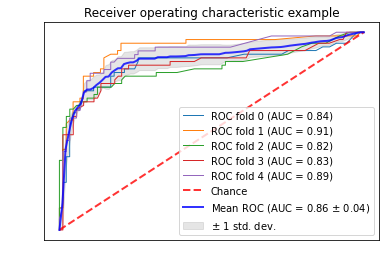

In [25]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
kf = StratifiedKFold()
lr_clf_pipe = pipe_filtered_2
for i, (train, test) in enumerate(kf.split(X, y)):
    lr_clf_pipe.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(lr_clf_pipe, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()


# the final test

In [26]:
# final test
best_clf = pipe_filtered_2
best_clf.fit(X,y)
pred = best_clf.predict(X_test)
print('score: ',roc_auc_score(y_test,pred))
print(confusion_matrix(y_test,pred))
print('fp: \n', X_test[(y_test != pred) & (y_test == 0)])
fn = X_test[(y_test != pred) & (y_test == 1)]
print('\n\nfn: \n', fn)

score:  0.8258317025440314
[[90 15]
 [15 58]]
fp: 
      Pclass                                           Name     Sex   Age  \
434       1                      Silvey, Mr. William Baird    male  50.0   
854       2  Carter, Mrs. Ernest Courtenay (Lilian Hughes)  female  44.0   
396       3                            Olsson, Miss. Elina  female  31.0   
235       3                   Harknett, Miss. Alice Phoebe  female   NaN   
137       1                    Futrelle, Mr. Jacques Heath    male  37.0   
578       3               Caram, Mrs. Joseph (Maria Elias)  female   NaN   
593       3                             Bourke, Miss. Mary  female   NaN   
852       3                        Boulos, Miss. Nourelain  female   9.0   
807       3                Pettersson, Miss. Ellen Natalia  female  18.0   
49        3  Arnold-Franchi, Mrs. Josef (Josefine Franchi)  female  18.0   
254       3       Rosblom, Mrs. Viktor (Helena Wilhelmina)  female  41.0   
745       1                   Crosby

In [27]:
X_test.dtypes
# X.iloc[0,:]

Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [28]:
newbie = [1,'Shumacher, Mr. Ariel','male',21,2,4,None,30,'E3','S']
def get_df_like_titanic(x):
    res = X.iloc[0:0,:].copy()
    res.append(x)
    return res
def will_you_survive(*params):
    res = X.iloc[0:0,:].copy()
    df = pd.DataFrame(np.atleast_2d(params),columns=X.columns)
    for x in X.columns:
        df[x]=df[x].astype(X[x].dtypes.name)
    print(df,'\n',df.dtypes)
    print('will you survive?: ',best_clf.predict(df)==1,
          '\nwith probability:',best_clf.predict_proba(df))
will_you_survive(*newbie)

   Pclass                  Name   Sex   Age  SibSp  Parch Ticket  Fare Cabin  \
0       1  Shumacher, Mr. Ariel  male  21.0      2      4   None  30.0    E3   

  Embarked  
0        S   
 Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
will you survive?:  [ True] 
with probability: [[0.38564473 0.61435527]]
